Import Libraries

In [ ]:
# 📦 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

Load Dataset

In [ ]:
# Load datasets
df_news = pd.read_csv('Combined_News_DJIA.csv', encoding='ISO-8859-1')
df_stock = pd.read_csv('formatted_stock_data.csv')

# Convert date columns
# Convert date columns
df_news['Date'] = pd.to_datetime(df_news['Date'])
df_stock['Date'] = pd.to_datetime(df_stock['Date'], format='%d-%m-%Y') # Specify the correct format for df_stock

# Check structure
print("🗞️ News Data")
print(df_news.columns)
print(df_news.head(2))

print("\n📈 Stock Data")
print(df_stock.columns)
print(df_stock.head(2))

🗞️ News Data
Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25'],
      dtype='object')
        Date  Label                                               Top1  \
0 2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...   
1 2008-08-11      1  b'Why wont America and Nato help us? If they w...   

                                          Top2  \
0      b'BREAKING: Musharraf to be impeached.'   
1  b'Bush puts foot down on Georgian conflict'   

                                                Top3  \
0  b'Russia Today: Columns of troops roll into So...   
1  b"Jewish Georgian minister: Thanks to Israeli ...   

                                                Top4  \
0  b'Russian tanks are moving towards the capital...   
1  b'Georgian army flees in disarray as Russians

In [ ]:
# Combine Top1 to Top25 columns
headline_columns = [f'Top{i}' for i in range(1, 26)]

df_news['Combined_News'] = df_news[headline_columns].astype(str).agg(' '.join, axis=1)
df_news = df_news[['Date', 'Combined_News']]  # Keep only relevant columns
df_news.head()

,Date,Combined_News
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou..."
1,2008-08-11,b'Why wont America and Nato help us? If they w...
2,2008-08-12,b'Remember that adorable 9-year-old who sang a...
3,2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...
4,2008-08-14,b'All the experts admit that we should legalis...


In [ ]:
# Clean news text: lowercase, remove special chars
df_news['Combined_News'] = df_news['Combined_News'].str.replace('[^a-zA-Z ]', '', regex=True)
df_news['Combined_News'] = df_news['Combined_News'].str.lower()

In [ ]:
# Merge on Date
merged_df = pd.merge(df_stock, df_news, on='Date', how='inner')

print("✅ Merged Dataset")
merged_df.head()

✅ Merged Dataset


,Date,Open,High,Low,Close,Volume,Ticker,Combined_News
0,2008-08-08,41.387430,43.160027,41.257728,43.005619,15116500.0,PG,bgeorgia downs two russian warplanes as countr...
1,2008-08-11,42.999458,43.166216,41.424498,42.882107,10843500.0,PG,bwhy wont america and nato help us if they won...
2,2008-08-12,42.752398,43.561493,42.678281,43.444141,14375000.0,PG,bremember that adorable yearold who sang at th...
3,2008-08-13,43.370024,43.382374,42.740038,42.987091,10701100.0,PG,b us refuses israel weapons to attack iran rep...
4,2008-08-14,42.956212,43.530609,42.684453,43.055031,9447400.0,PG,ball the experts admit that we should legalise...


In [ ]:
# import torch
# print("CUDA Available:", torch.cuda.is_available())
# print("Current Device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
# print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset
import torch
import pandas as pd
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

In [ ]:
def get_sentiments_batched(texts, batch_size=32):
    dataset = NewsDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    all_results = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing Batches"):
            tokens = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = softmax(outputs.logits, dim=-1).cpu().numpy()

            for prob in probs:
                all_results.append({
                    'negative': prob[0],
                    'neutral': prob[1],
                    'positive': prob[2]
                })

    return pd.DataFrame(all_results)


In [ ]:
sentiment_df = get_sentiments_batched(merged_df['Combined_News'].tolist(), batch_size=32)
merged_df = pd.concat([merged_df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)
merged_df.head()

Processing Batches:   0%|          | 0/622 [00:00<?, ?it/s]Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Processing Batches: 100%|██████████| 622/622 [10:33<00:00,  1.02s/it]


,Date,Open,High,Low,Close,Volume,Ticker,Combined_News,negative,neutral,positive
0,2008-08-08,41.387430,43.160027,41.257728,43.005619,15116500.0,PG,bgeorgia downs two russian warplanes as countr...,0.026586,0.621704,0.351710
1,2008-08-11,42.999458,43.166216,41.424498,42.882107,10843500.0,PG,bwhy wont america and nato help us if they won...,0.027521,0.316329,0.656149
2,2008-08-12,42.752398,43.561493,42.678281,43.444141,14375000.0,PG,bremember that adorable yearold who sang at th...,0.031536,0.385824,0.582640
3,2008-08-13,43.370024,43.382374,42.740038,42.987091,10701100.0,PG,b us refuses israel weapons to attack iran rep...,0.049237,0.314911,0.635852
4,2008-08-14,42.956212,43.530609,42.684453,43.055031,9447400.0,PG,ball the experts admit that we should legalise...,0.046462,0.212067,0.741471


In [ ]:
merged_df.head(20)

,Date,Open,High,Low,Close,Volume,Ticker,Combined_News,negative,neutral,positive
0,2008-08-08,41.387430,43.160027,41.257728,43.005619,15116500.0,PG,bgeorgia downs two russian warplanes as countr...,0.026586,0.621704,0.351710
1,2008-08-11,42.999458,43.166216,41.424498,42.882107,10843500.0,PG,bwhy wont america and nato help us if they won...,0.027521,0.316329,0.656149
2,2008-08-12,42.752398,43.561493,42.678281,43.444141,14375000.0,PG,bremember that adorable yearold who sang at th...,0.031536,0.385824,0.582640
3,2008-08-13,43.370024,43.382374,42.740038,42.987091,10701100.0,PG,b us refuses israel weapons to attack iran rep...,0.049237,0.314911,0.635852
4,2008-08-14,42.956212,43.530609,42.684453,43.055031,9447400.0,PG,ball the experts admit that we should legalise...,0.046462,0.212067,0.741471
5,2008-08-15,43.536777,44.457050,43.055026,44.222347,17615400.0,PG,bmom of missing gay man too bad hes not a year...,0.024322,0.630879,0.344799
6,2008-08-18,44.049419,44.469408,43.870306,44.018536,12509100.0,PG,bin an afghan prison the majority of female pr...,0.023190,0.380904,0.595906
7,2008-08-19,43.864142,44.296487,43.635622,43.678856,12332900.0,PG,bman arrested and locked up for five hours aft...,0.020900,0.298098,0.681001
8,2008-08-20,43.654135,43.703547,43.036505,43.419437,10981000.0,PG,btwo elderly chinese women have been sentenced...,0.039406,0.115855,0.844739
9,2008-08-21,43.129156,43.302092,42.795635,43.172390,9722500.0,PG,bbritish resident held in guantanamo bay wins ...,0.033587,0.300860,0.665553


In [ ]:
import pandas as pd

# Check general dataset info
print("\n🔹 Dataset Overview:")
print(merged_df.info())

# Check missing values
print("\n🔹 Missing Values Per Column:")
print(merged_df.isnull().sum())

# Check for duplicates
print("\n🔹 Duplicate Rows:", merged_df.duplicated().sum())

# Show basic statistics
print("\n🔹 Descriptive Statistics:")
print(merged_df.describe())

# Check if sentiment scores sum to ~1
merged_df['sentiment_sum'] = merged_df['negative'] + merged_df['neutral'] + merged_df['positive']
print("\n🔹 Sentiment Score Check (Ideally ~1):")
print(merged_df[['negative', 'neutral', 'positive', 'sentiment_sum']].head(10))


🔹 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19890 entries, 0 to 19889
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           19890 non-null  datetime64[ns]
 1   Open           19890 non-null  float64       
 2   High           19890 non-null  float64       
 3   Low            19890 non-null  float64       
 4   Close          19890 non-null  float64       
 5   Volume         19890 non-null  float64       
 6   Ticker         19890 non-null  object        
 7   Combined_News  19890 non-null  object        
 8   negative       19890 non-null  float32       
 9   neutral        19890 non-null  float32       
 10  positive       19890 non-null  float32       
dtypes: datetime64[ns](1), float32(3), float64(5), object(2)
memory usage: 1.4+ MB
None

🔹 Missing Values Per Column:
Date             0
Open             0
High             0
Low              0
Close        

In [ ]:
# Optimize float64 -> float32 (saves memory)
float_cols = ["Open", "High", "Low", "Close", "Volume"]
merged_df[float_cols] = merged_df[float_cols].astype("float32")

# Convert categorical columns
merged_df["Ticker"] = merged_df["Ticker"].astype("category")

# Confirm memory reduction
print("\n🔹 Optimized Dataset Info:")
print(merged_df.info())


🔹 Optimized Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19890 entries, 0 to 19889
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           19890 non-null  datetime64[ns]
 1   Open           19890 non-null  float32       
 2   High           19890 non-null  float32       
 3   Low            19890 non-null  float32       
 4   Close          19890 non-null  float32       
 5   Volume         19890 non-null  float32       
 6   Ticker         19890 non-null  category      
 7   Combined_News  19890 non-null  object        
 8   negative       19890 non-null  float32       
 9   neutral        19890 non-null  float32       
 10  positive       19890 non-null  float32       
 11  sentiment_sum  19890 non-null  float32       
dtypes: category(1), datetime64[ns](1), float32(9), object(1)
memory usage: 1.0+ MB
None


In [ ]:
# Check negative or zero prices
print("\n🔹 Stocks with Zero or Negative Prices:")
print(merged_df[(merged_df["Open"] <= 0) | (merged_df["Close"] <= 0)])

# Check extremely high trading volume
print("\n🔹 Top 10 Largest Trading Volumes:")
print(merged_df.nlargest(10, "Volume"))


🔹 Stocks with Zero or Negative Prices:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Ticker, Combined_News, negative, neutral, positive, sentiment_sum]
Index: []

🔹 Top 10 Largest Trading Volumes:
            Date      Open      High       Low     Close        Volume Ticker  \
14531 2011-01-06  0.399391  0.443411  0.398244  0.443181  3.493312e+09   NVDA   
14560 2011-02-17  0.520904  0.596335  0.518382  0.588769  3.470096e+09   NVDA   
14535 2011-01-12  0.465879  0.535807  0.464274  0.535348  3.431896e+09   NVDA   
14682 2011-08-12  0.340239  0.340697  0.290487  0.295301  3.195784e+09   NVDA   
14111 2009-05-08  0.240735  0.240735  0.208866  0.212076  2.930564e+09   NVDA   
14258 2009-12-07  0.363395  0.377151  0.346200  0.368897  2.732184e+09   NVDA   
14534 2011-01-11  0.479406  0.483992  0.455562  0.465650  2.711088e+09   NVDA   
14536 2011-01-13  0.529617  0.546583  0.513109  0.536265  2.695192e+09   NVDA   
14419 2010-07-29  0.215515  0.220100  0.207949  0.20932

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


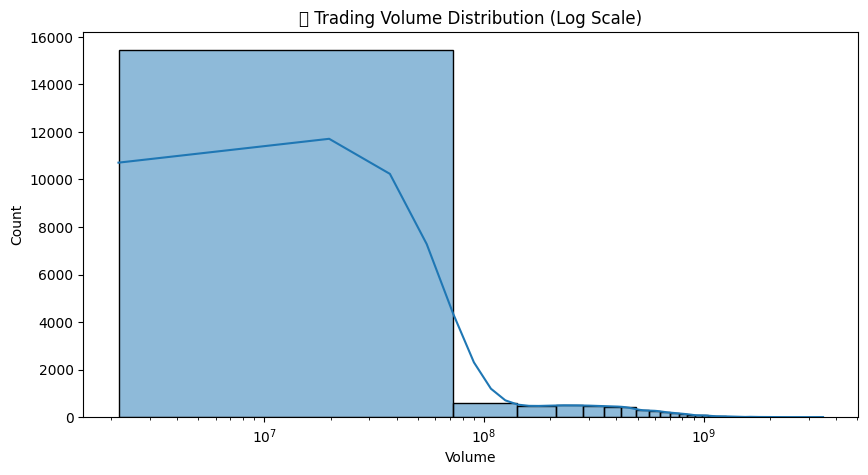


🔹 Volume Statistics:
count    1.989000e+04
mean     1.182410e+08
std      2.480690e+08
min      2.165700e+06
25%      1.052370e+07
50%      1.829475e+07
75%      5.621722e+07
max      3.493312e+09
Name: Volume, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot volume distribution (log scale to handle large values)
plt.figure(figsize=(10, 5))
sns.histplot(merged_df["Volume"], bins=50, kde=True)
plt.xscale("log")  # Log scale to see variations better
plt.title("🔹 Trading Volume Distribution (Log Scale)")
plt.xlabel("Volume")
plt.ylabel("Count")
plt.show()

# Print basic stats
print("\n🔹 Volume Statistics:")
print(merged_df["Volume"].describe())


🔹 Volume values capped at: 1356090240.00


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


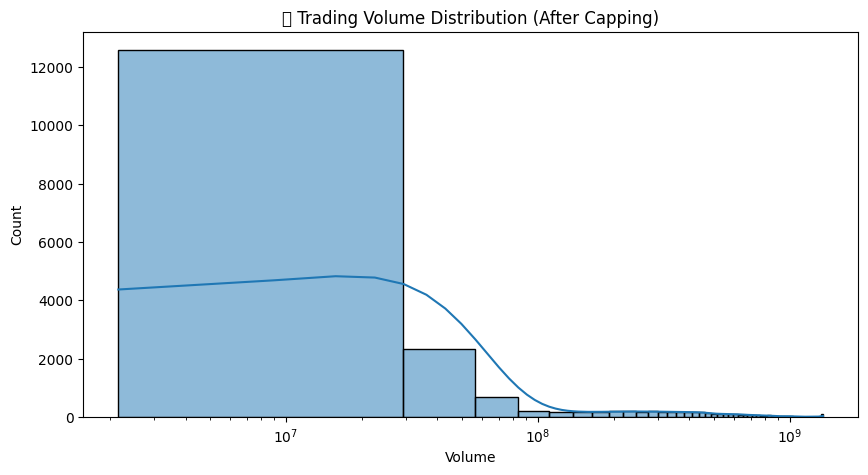

In [ ]:
import numpy as np

# Compute the 99.5th percentile threshold
upper_limit = merged_df["Volume"].quantile(0.995)

# Clip values beyond this threshold
merged_df["Volume"] = np.where(merged_df["Volume"] > upper_limit, upper_limit, merged_df["Volume"])

print(f"🔹 Volume values capped at: {upper_limit:.2f}")

# Re-plot the fixed distribution
plt.figure(figsize=(10, 5))
sns.histplot(merged_df["Volume"], bins=50, kde=True)
plt.xscale("log")
plt.title("🔹 Trading Volume Distribution (After Capping)")
plt.xlabel("Volume")
plt.ylabel("Count")
plt.show()

In [ ]:
import numpy as np

merged_df["Volume"] = np.log1p(merged_df["Volume"])  # Log transformation

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


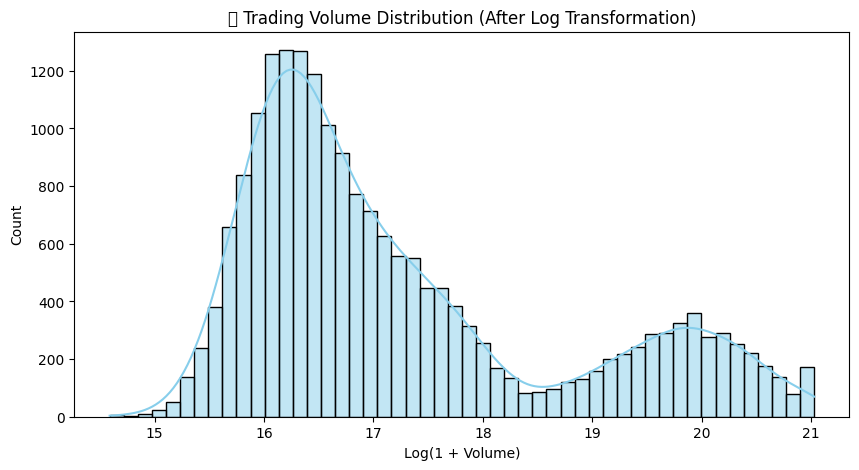

In [ ]:
# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(merged_df["Volume"], bins=50, kde=True, color="skyblue", edgecolor="black")

plt.title("📊 Trading Volume Distribution (After Log Transformation)")
plt.xlabel("Log(1 + Volume)")
plt.ylabel("Count")
plt.show()

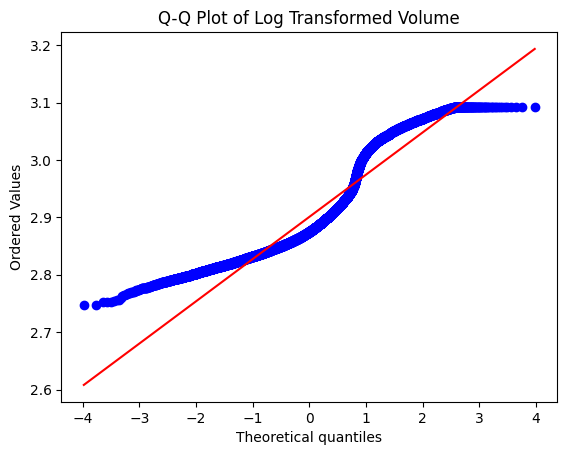

In [ ]:
import scipy.stats as stats

# Q-Q plot to check normality
stats.probplot(np.log1p(merged_df["Volume"]), dist="norm", plot=plt)
plt.title("Q-Q Plot of Log Transformed Volume")
plt.show()


In [ ]:
from scipy.stats import skew, kurtosis

log_volume = np.log1p(merged_df["Volume"])
print("Skewness:", skew(log_volume))
print("Kurtosis:", kurtosis(log_volume))

Skewness: 0.9020031940628018
Kurtosis: -0.32903733030697957


In [ ]:
# Compute Simple Moving Averages (SMA)
merged_df['SMA_10'] = merged_df['Close'].rolling(window=10).mean()
merged_df['SMA_20'] = merged_df['Close'].rolling(window=20).mean()

In [ ]:
# Compute Exponential Moving Averages (EMA)
merged_df['EMA_10'] = merged_df['Close'].ewm(span=10, adjust=False).mean()
merged_df['EMA_20'] = merged_df['Close'].ewm(span=20, adjust=False).mean()

In [ ]:
# Define a function to compute RSI (Relative Strength Index)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [ ]:
# Compute RSI for a 14-day window
merged_df['RSI'] = compute_rsi(merged_df['Close'], period=14)

In [ ]:
# Compute MACD and Signal Line
merged_df['EMA_12'] = merged_df['Close'].ewm(span=12, adjust=False).mean()
merged_df['EMA_26'] = merged_df['Close'].ewm(span=26, adjust=False).mean()
merged_df['MACD'] = merged_df['EMA_12'] - merged_df['EMA_26']
merged_df['Signal_Line'] = merged_df['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
  # Display the first few rows to verify computed indicators
  print("Technical Indicators Computed:")
  print(merged_df[['Close', 'SMA_10', 'SMA_20', 'EMA_10', 'EMA_20', 'RSI', 'MACD', 'Signal_Line']].head(50))

Technical Indicators Computed:
        Close     SMA_10     SMA_20     EMA_10     EMA_20        RSI  \
0   43.005619        NaN        NaN  43.005619  43.005619        NaN   
1   42.882107        NaN        NaN  42.983162  42.993856        NaN   
2   43.444141        NaN        NaN  43.066977  43.036740        NaN   
3   42.987091        NaN        NaN  43.052452  43.032012        NaN   
4   43.055031        NaN        NaN  43.052921  43.034204        NaN   
5   44.222347        NaN        NaN  43.265544  43.147361        NaN   
6   44.018536        NaN        NaN  43.402451  43.230330        NaN   
7   43.678856        NaN        NaN  43.452707  43.273046        NaN   
8   43.419437        NaN        NaN  43.446658  43.286988        NaN   
9   43.172390  43.388556        NaN  43.396791  43.276074        NaN   
10  44.228535  43.510847        NaN  43.548017  43.366785        NaN   
11  43.314445  43.554081        NaN  43.505550  43.361800        NaN   
12  43.135323  43.523199        N

In [ ]:
# Calculate next day's Close price within each ticker group
merged_df['Next_Close'] = merged_df.groupby('Ticker')['Close'].shift(-1)

# Calculate the percentage change from today's Close to the next day's Close
merged_df['Price_Change_Tomorrow'] = ((merged_df['Next_Close'] - merged_df['Close']) / merged_df['Close']) * 100

# Define a threshold to label the movement
def classify_movement(change, threshold=0.5):
    if change > threshold:
        return 'Up'
    elif change < -threshold:
        return 'Down'
    else:
        return 'Stable'

merged_df['Movement'] = merged_df['Price_Change_Tomorrow'].apply(lambda x: classify_movement(x, threshold=0.5))

# Drop rows with NaN values created by shift or rolling windows
merged_df.dropna(subset=['SMA_10', 'SMA_20', 'RSI', 'MACD', 'Signal_Line', 'Next_Close', 'Movement'], inplace=True)

print(merged_df[['Date', 'Ticker', 'Close', 'Price_Change_Tomorrow', 'Movement']].head(15))

         Date Ticker      Close  Price_Change_Tomorrow Movement
19 2008-09-05     PG  43.715908               2.246388       Up
20 2008-09-08     PG  44.697937              -0.663233     Down
21 2008-09-09     PG  44.401485               0.695506       Up
22 2008-09-10     PG  44.710300               0.953147       Up
23 2008-09-11     PG  45.136456               0.095781   Stable
24 2008-09-12     PG  45.179688              -1.380731     Down
25 2008-09-15     PG  44.555878              -0.194066   Stable
26 2008-09-16     PG  44.469410              -1.472199     Down
27 2008-09-17     PG  43.814732               0.521550       Up
28 2008-09-18     PG  44.043247              -1.332213     Down
29 2008-09-19     PG  43.456497              -3.297328     Down
30 2008-09-22     PG  42.023594              -1.117006     Down
31 2008-09-23     PG  41.554188               2.170064       Up
32 2008-09-24     PG  42.455940              -0.334613   Stable
33 2008-09-25     PG  42.313877         

<ipython-input-29-5e7bb02a954e>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df['Next_Close'] = merged_df.groupby('Ticker')['Close'].shift(-1)


In [ ]:
print(merged_df['Movement'].value_counts())

Movement
Stable    6948
Up        6806
Down      6107
Name: count, dtype: int64


In [ ]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19861 entries, 19 to 19888
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   19861 non-null  datetime64[ns]
 1   Open                   19861 non-null  float32       
 2   High                   19861 non-null  float32       
 3   Low                    19861 non-null  float32       
 4   Close                  19861 non-null  float32       
 5   Volume                 19861 non-null  float64       
 6   Ticker                 19861 non-null  category      
 7   Combined_News          19861 non-null  object        
 8   negative               19861 non-null  float32       
 9   neutral                19861 non-null  float32       
 10  positive               19861 non-null  float32       
 11  sentiment_sum          19861 non-null  float32       
 12  SMA_10                 19861 non-null  float64       
 13  SMA_2

In [ ]:
# After computing technical indicators, save the DataFrame:
merged_df.to_csv("merged_df_with_indicators.csv", index=False)

# Train and Evaluate a Baseline Random Forest Model

1. Feature Selection and Target Definition

In [ ]:
merged_df['Sentiment_Score'] = merged_df['positive'] - merged_df['negative']

2. Prepare the Data for Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Select features: adjust feature_cols as needed.
feature_cols = ['Close', 'Volume', 'SMA_10', 'SMA_20', 'EMA_10', 'EMA_20', 'RSI', 'MACD', 'Sentiment_Score']
X = merged_df[feature_cols]

# Define the target variable: Movement ("Up", "Down", "Stable")
y = merged_df['Movement']

In [ ]:
# Encode target labels to integers for the classifier
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # e.g., Down=0, Stable=1, Up=2

In [ ]:
# Split the data (we do not shuffle because of time-series nature)
train_size = int(0.8 * len(merged_df))
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y_encoded[:train_size]
y_test = y_encoded[train_size:]

In [ ]:
print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Train samples: 15888
Test samples: 3973


3. Train a Random Forest Classifier

Classification Report:
              precision    recall  f1-score   support

        Down       0.28      0.38      0.32      1077
      Stable       0.44      0.47      0.46      1626
          Up       0.37      0.22      0.28      1270

    accuracy                           0.37      3973
   macro avg       0.36      0.36      0.35      3973
weighted avg       0.37      0.37      0.36      3973



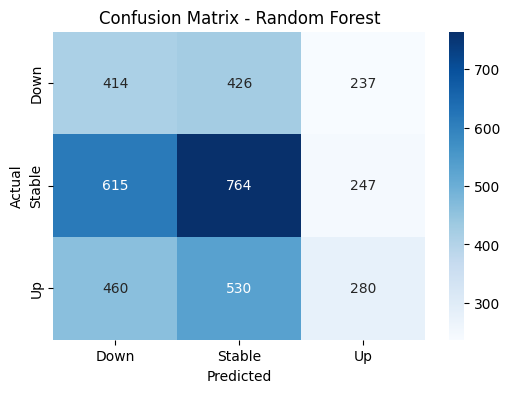

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_dist,
                                   scoring='f1_macro',
                                   n_iter=10, cv=3,
                                   random_state=42)
random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)


Best params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}


Classification Report (Tuned Model):

              precision    recall  f1-score   support

        Down       0.28      0.34      0.31      1077
      Stable       0.45      0.56      0.50      1626
          Up       0.41      0.20      0.27      1270

    accuracy                           0.38      3973
   macro avg       0.38      0.37      0.36      3973
weighted avg       0.39      0.38      0.37      3973



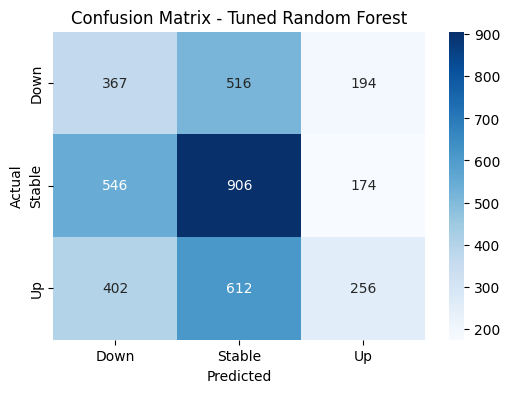

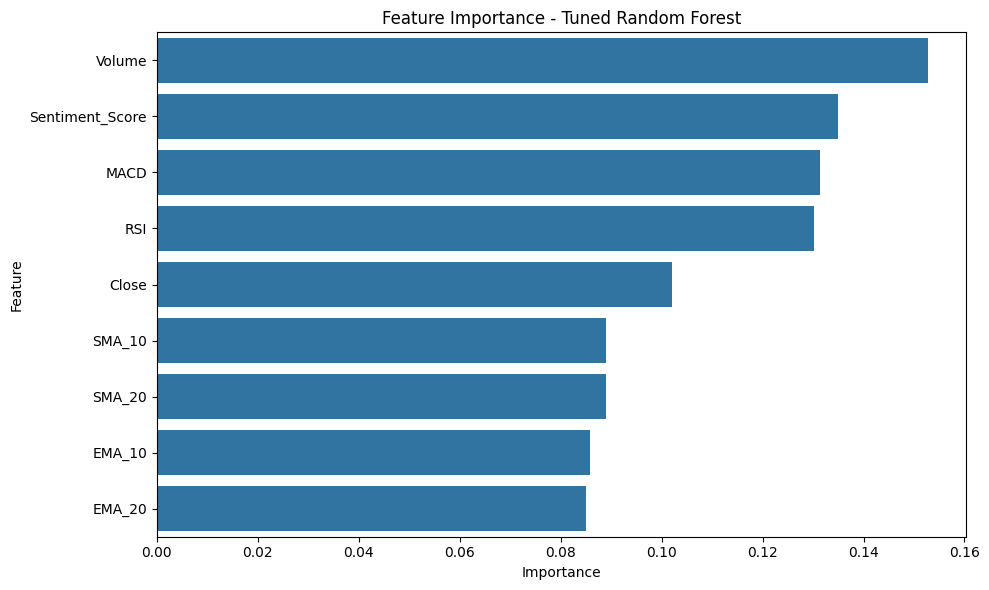

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reinitialize the RandomForest with the best parameters and balanced class weights
rf_tuned = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'
)

# Train the tuned model on the training data
rf_tuned.fit(X_train, y_train)

# Predict on the test set
y_pred_tuned = rf_tuned.predict(X_test)

# Output the classification report
print("Classification Report (Tuned Model):\n")
print(classification_report(y_test, y_pred_tuned, target_names=label_encoder.classes_))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()

# Optional: Plot feature importance to understand which features are driving the predictions
importances = rf_tuned.feature_importances_
feat_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df)
plt.title("Feature Importance - Tuned Random Forest")
plt.tight_layout()
plt.show()


# Basic XGBoost Implementation

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.31      0.32      1077
           1       0.46      0.62      0.52      1626
           2       0.39      0.25      0.31      1270

    accuracy                           0.42      3973
   macro avg       0.40      0.39      0.38      3973
weighted avg       0.41      0.42      0.40      3973



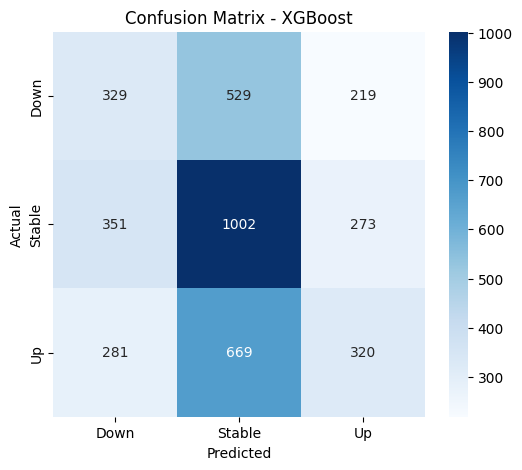

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit the model
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
random_search_xgb = RandomizedSearchCV(xgb, param_grid,
                                       scoring='f1_macro',
                                       n_iter=15, cv=3,
                                       random_state=42, verbose=1)

random_search_xgb.fit(X_train, y_train)

print("Best Params:", random_search_xgb.best_params_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1.0}


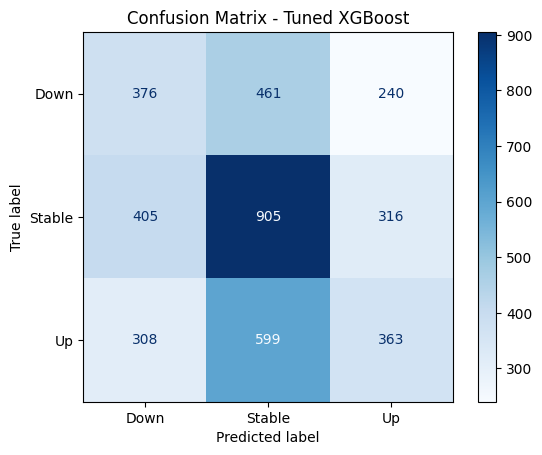

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.35      0.35      1077
           1       0.46      0.56      0.50      1626
           2       0.39      0.29      0.33      1270

    accuracy                           0.41      3973
   macro avg       0.40      0.40      0.39      3973
weighted avg       0.41      0.41      0.41      3973



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train tuned XGBoost
xgb_tuned = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    subsample=1.0,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.3,
    gamma=0,
    colsample_bytree=1.0
)

xgb_tuned.fit(X_train, y_train)
y_pred_xgb_tuned = xgb_tuned.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Stable', 'Up'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Tuned XGBoost")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_tuned))


Fitting 3 folds for each of 24 candidates, totalling 72 fits


<Figure size 600x500 with 0 Axes>

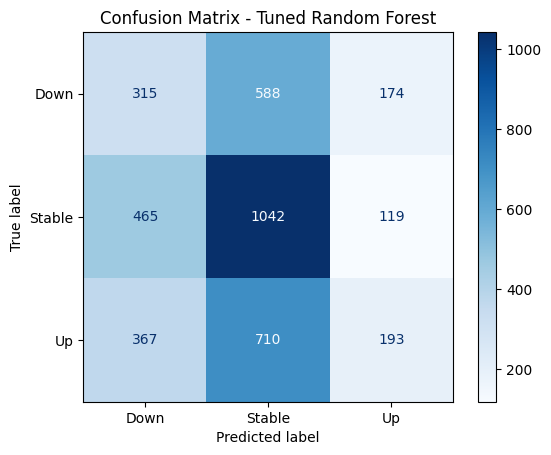

Classification Report - Tuned Random Forest:
              precision    recall  f1-score   support

        Down       0.27      0.29      0.28      1077
      Stable       0.45      0.64      0.53      1626
          Up       0.40      0.15      0.22      1270

    accuracy                           0.39      3973
   macro avg       0.37      0.36      0.34      3973
weighted avg       0.38      0.39      0.36      3973



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Define parameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Step 2: Initialize the base model
rf = RandomForestClassifier(random_state=42)

# Step 3: Grid Search
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

# Step 4: Best model
best_rf = grid_rf.best_estimator_

# Step 5: Predict on test data
y_pred_rf_tuned = best_rf.predict(X_test)

# Step 6: Confusion Matrix
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
disp_rf_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tuned,
                                       display_labels=['Down', 'Stable', 'Up'])

plt.figure(figsize=(6, 5))
disp_rf_tuned.plot(cmap='Blues')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.grid(False)
plt.show()

# Step 7: Classification Report
print("Classification Report - Tuned Random Forest:")
print(classification_report(y_test, y_pred_rf_tuned, target_names=['Down', 'Stable', 'Up']))

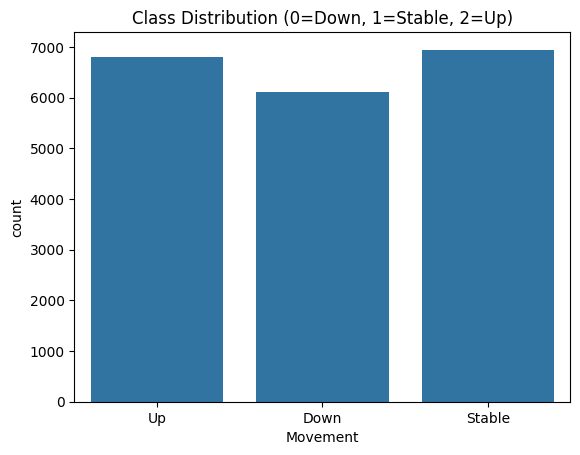

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title("Class Distribution (0=Down, 1=Stable, 2=Up)")
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


print("Before SMOTE:\n", pd.Series(y_train).value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_resampled).value_counts())


Before SMOTE:
 2    5536
1    5322
0    5030
Name: count, dtype: int64

After SMOTE:
 2    5536
0    5536
1    5536
Name: count, dtype: int64


In [ ]:
best_rf.fit(X_resampled, y_resampled)
y_pred_rf_resampled = best_rf.predict(X_test)

Classification Report - Resampled RF:

              precision    recall  f1-score   support

           0       0.28      0.32      0.30      1077
           1       0.44      0.63      0.52      1626
           2       0.42      0.14      0.22      1270

    accuracy                           0.39      3973
   macro avg       0.38      0.36      0.34      3973
weighted avg       0.39      0.39      0.36      3973



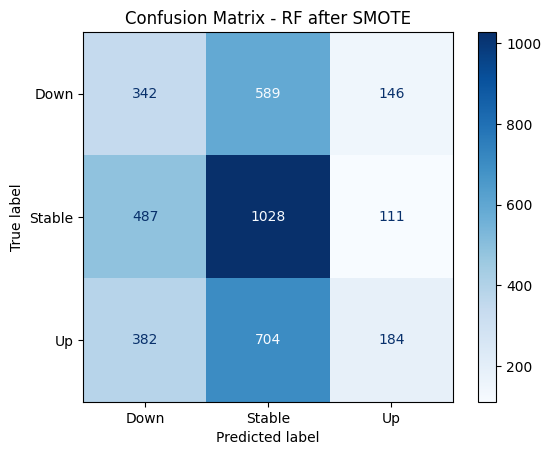

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Classification Report - Resampled RF:\n")
print(classification_report(y_test, y_pred_rf_resampled))

cm_resampled = confusion_matrix(y_test, y_pred_rf_resampled)
disp_resampled = ConfusionMatrixDisplay(confusion_matrix=cm_resampled,
                                        display_labels=['Down', 'Stable', 'Up'])
disp_resampled.plot(cmap="Blues")
plt.title("Confusion Matrix - RF after SMOTE")
plt.show()